# Testing 

get going

In [223]:
data class Bla(val x1:Int, val y1:Int, val x2:Int, val y2:Int)

In [224]:
val b = Bla(0, 10, 100, 100)
println(b)

Bla(x1=0, y1=10, x2=100, y2=100)


How about some functions to get some random values

In [225]:
import kotlin.random.Random

fun randomColor(): Color {
    val colorRange = 0..255
    val r = colorRange.random()
    val g = colorRange.random()
    val b = colorRange.random()
    return Color(r, g, b)
}

fun randomGrey(): Color {
    val colorRange = 0..255
    val c = colorRange.random()
    return Color(c, c, c)
}
data class Point(val x:Int, val y:Int)
data class Size(val width:Int, val height:Int)
fun randomOffset(size: Size) =
    Point(
        x = Random.nextInt(0, size.width),
        y = Random.nextInt(0, size.height)
    )
   
fun randomRadius(min:Int = 5, max:Int = 100) = Random.nextInt(min, max)

Now lets draw something

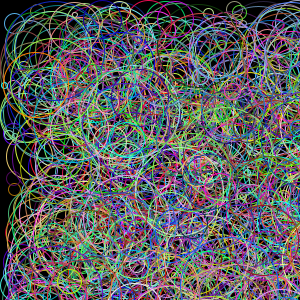

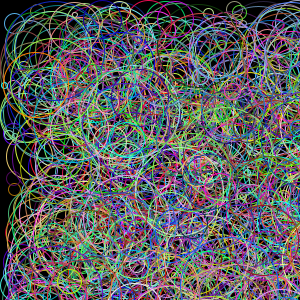

In [238]:
import java.awt.Color
import java.awt.image.BufferedImage

val width = 300
val height = width
val size = Size(width, height)

val image = BufferedImage(width, height, BufferedImage.TYPE_INT_ARGB)

val graphics = image.createGraphics()
with(graphics) {
    background = Color.BLACK
    clearRect(0, 0, size.width, size.height)
    setRenderingHint(
        java.awt.RenderingHints.KEY_ANTIALIASING,
        java.awt.RenderingHints.VALUE_ANTIALIAS_ON
    )
    repeat(ovalCount) {
        color = randomColor()
        val radius = randomRadius()
        val center = randomOffset(size)
        drawOval(center.x, center.y, radius, radius)
       
    }
}
graphics.dispose()

DISPLAY(image)
DISPLAY(image)

Change the ovalCount to increase or decrease how many scribbles we draw.

In [234]:
val ovalCount =1000

Let's try another one

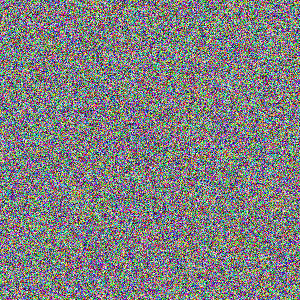

In [228]:
val graphics = image.createGraphics()
with(graphics) {
    background = Color.BLACK
    clearRect(0, 0, size.width, size.height)
    setRenderingHint(
        java.awt.RenderingHints.KEY_ANTIALIASING,
        java.awt.RenderingHints.VALUE_ANTIALIAS_ON
    )
    for (x in 0..size.width)
        for (y in 0..size.height) {
            color = randomColor()
            drawRect(x, y, 1, 1)
        }

}
graphics.dispose()
image